In [1]:
library(statsecol)
library(jagsUI)
library(MCMCvis)
library(ggplot2)
data("voles")

Warning message:
“package ‘jagsUI’ was built under R version 4.1.1”
Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


In [ ]:
sink("voles.txt")
cat("
model{
  # Prior specification
  psi1 ~ dunif(0, 1)
  mu ~ dunif(-10, 10)
  sigma ~ dunif(0, 5)
  tau <- sigma^(-2)
  b0 ~ dnorm(0, 0.1)
  b1 ~ dnorm(0, 0.1)
  a0 ~ dnorm(0, 0.1)
  a1 ~ dnorm(0, 0.1)

  for(site in 1:n.sites) {
    for(year in 2:n.years) {
      logit(gamma[site, year - 1]) <- b0 + b1 * connectivity[site]
      logit(epsilon[site, year - 1]) <- a0 + a1 * length[site]
    }
  }
   
  # Likelihood
  for(site in 1:n.sites){
    z[site, 1] ~ dbern(psi1)
    for(year in 2:n.years) {      
      z[site, year] ~ dbern(
        (1 - z[site, year - 1]) * gamma[site, year - 1] + z[site, year - 1] * (1 - epsilon[site, year - 1])
      )
    }
  }

  for(site in 1:n.sites) {
    for(year in 1:n.years) {
      q[site, year] ~ dnorm(mu, tau)
      logit(p[site, year]) <- q[site, year]
      y[site, year] ~ dbinom(p[site, year] * z[site, year], visits[site, year])

      #ysim[site, year] ~ dbin(p[site, year] * z[site, year], visits[site, year])
      #yexp[site, year] <- p[site, year] * visits[site, year] * z[site, year] + 0.001
      #x2.obs[site, year] <- pow((y[site, year] - yexp[site, year]), 2) / (yexp[site, year])    # for observed data
      #x2.sim[site, year] <- pow((ysim[site, year] - yexp[site, year]), 2) / (yexp[site, year]) # for 'ideal' data
      #ft.obs[site, year] <- pow(sqrt(y[site, year]) - sqrt(yexp[site, year]), 2)               # for observed data
      #ft.sim[site, year] <- pow(sqrt(ysim[site, year]) - sqrt(yexp[site, year]), 2)            # for 'ideal' data
    }
  }

  #Chi2.obs <- sum(x2.obs[,])
  #Chi2.sim <- sum(x2.sim[,])
  #Chi2.ratio <- x2.obs/x2.sim
  #FT.obs <- sum(ft.obs[,])
  #FT.sim <- sum(ft.sim[,])
  #FT.ratio <- FT.obs/FT.sim

  for(year in 1:n.years){
    propocc[year] <- sum(z[, year]) / n.sites   
  }
}
",fill = TRUE)
sink()

In [3]:
visits = as.matrix(voles[,c("j1", "j2", "j3", "j4")])
obs = as.matrix(voles[, c("y1", "y2", "y3", "y4")])

In [ ]:
# Bundle data
volesdata <- list(
    y = obs,
    n.years = 4,
    n.sites = nrow(voles),
    visits = visits,
    connectivity = voles$Connectivity,
    length = voles$Length
)

volesinits <- function() {
  list(psi1 = runif(1, 0, 1),
       mu = runif(1, 0, 1),
       sigma = runif(1, 0, 3),
       b0 = runif(1, 0, 1),
       b1 = runif(1, 0, 1),
       a0 = runif(1, 0, 1),
       a1 = runif(1, 0, 1),
       z = ifelse(obs>0,1,0))
}

# Parameters monitored
volesparams <- c("gamma", "epsilon", "p", "propocc", 
                 "Chi2.obs", "Chi2.sim", "ft.obs", "ft.sim")

# MCMC settings
ni <- 10000
nt <- 6
nb <- 3000
nc <- 3

volesout <- jags(
    data = volesdata,
    inits = volesinits,
    parameters.to.save = volesparams,
    model.file = "voles.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)

In [ ]:
MCMCtrace(volesout,                 #the fitted model
          params = volesparams[1:3],   #core model parameters
          iter = ni,                 #plot all iterations
          pdf = FALSE,               #DON'T write to a PDF
          type = "trace",
          ind=TRUE)

Year,Estimate,Lower,Upper
<int>,<dbl>,<dbl>,<dbl>
2009,0.6335433,0.5438596,0.7456140
2010,0.8219982,0.7456140,0.8859649
2011,0.9089734,0.8771930,0.9429825
2012,0.8812344,0.7631579,0.9561404


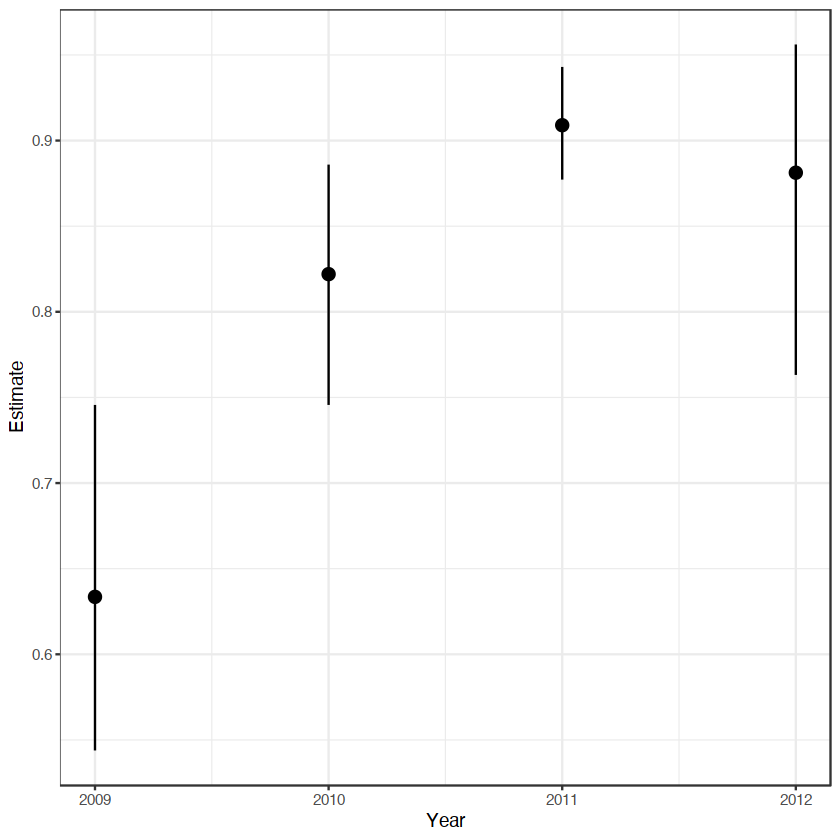

In [81]:
# burnet_dyn <- data.frame(Year = c(1:4,seq(1.5,114.5,1),seq(1.5,114.5,1)),
#                          Parameter = c(rep("Occupancy",4),
#                                        rep("Colonisation",114),
#                                        rep("Extinction",114)),
#                          Estimate = c(volesout$mean$propocc,
#                                       volesout$mean$gamma,
#                                       volesout$mean$epsilon),
#                          Lower = c(volesout$q2.5$propocc,
#                                    volesout$q2.5$gamma,
#                                    volesout$q2.5$epsilon),
#                          Upper = c(volesout$q97.5$propocc,
#                                    volesout$q97.5$gamma,
#                                    volesout$q97.5$epsilon))

# colonisation <- data.frame(
#     Site=c(1:114),
#     Estimate=volesout$mean$gamma,
#     Lower=volesout$q2.5$gamma,
#     Upper=volesout$q97.5$gamma
# )

occupancy <- data.frame(
    Year=c(2009:2012),
    Estimate=volesout$mean$propocc,
    Lower=volesout$q2.5$propocc,
    Upper=volesout$q97.5$propocc
)

# ggplot(data = colonisation, aes(x=Site,y=Estimate)) + 
#   geom_errorbar(aes(ymin=Lower, ymax=Upper), width=0) +
#   geom_point(size=3) +
#   theme_bw()

ggplot(data = occupancy, aes(x=Year,y=Estimate)) + 
  geom_errorbar(aes(ymin=Lower, ymax=Upper), width=0) +
  geom_point(size=3) +
  theme_bw()

occupancy

In [83]:
MCMCsummary(
    volesout,
    params =  volesparams[1:3]) #out parameters of interest

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"gamma[1,1]",0.7199401,0.11369119,0.4897971,0.7238830,0.9282071,1.00,3501
"gamma[2,1]",0.4446712,0.10350521,0.2396300,0.4458150,0.6536716,1.00,1128
"gamma[3,1]",0.7509322,0.11242267,0.5171007,0.7585722,0.9466319,1.00,3501
"gamma[4,1]",0.7959327,0.10832679,0.5634702,0.8076920,0.9707421,1.00,3501
"gamma[5,1]",0.7735398,0.11073632,0.5409900,0.7830105,0.9595694,1.00,3501
"gamma[6,1]",0.7197276,0.11369619,0.4895305,0.7235632,0.9280890,1.00,3501
"gamma[7,1]",0.6429639,0.11298498,0.4200332,0.6422553,0.8671885,1.00,3501
"gamma[8,1]",0.6763734,0.11383825,0.4479966,0.6761325,0.8975607,1.00,3501
"gamma[9,1]",0.9962021,0.01441829,0.9649589,0.9997973,1.0000000,1.05,3501


In [28]:
length(c(rep("Occupancy",4),
    rep("Colonisation",114),
    rep("Extinction",114)))

[1] 232

In [30]:
volesout$mean$propocc

[1] 0.6924749 0.8696468 0.9197450 0.9289380